
# **Facial Landmark Detection com Dlib**

#### **Iremos aprender:**
1. Aplicar o Facial Landmark Detection


**INSTALAR PREVIAMENTE**

1. cmake

2. vs_BuildTools com pacotes c++ e cmake

3. pip install cmake

4. pip install dlib

**Facial landmark** é um termo usado em visão computacional e processamento de imagens para descrever pontos específicos e predefinidos no rosto humano que representam características faciais significativas. Esses pontos são usados para identificar e acompanhar a posição de elementos importantes do rosto, como olhos, sobrancelhas, nariz, boca e contornos faciais.

Antes de identificar landmarks faciais, o Dlib precisa encontrar o rosto na imagem:

O Dlib usa o Histograma de Gradientes Orientados (HOG) ou um modelo de detecção baseado em CNN para localizar faces em uma imagem.
O HOG divide a imagem em pequenas regiões, analisa os gradientes de intensidade e os utiliza para construir um modelo de características que é eficaz para identificar formas gerais de rostos.

**HOG**

O HOG analisa gradientes (mudanças na intensidade da luz) em uma imagem e representa essas mudanças de forma compacta, capturando a estrutura e a forma dos objetos.

- Divisão da Imagem:

    - A imagem é dividida em pequenas células, geralmente de 8x8 pixels.

- Cálculo dos Gradientes:

    - Para cada célula, o HOG calcula a direção e a magnitude do gradiente de intensidade. Isso é feito usando derivadas (dx e dy).

- Criação de Histograma:

    - As direções dos gradientes são agrupadas em bins (intervalos de ângulos, como 0∘, 20∘, 40∘, etc.).
    - O número de gradientes em cada direção é registrado, criando um histograma.

- Normalização:

    - Para lidar com variações de iluminação, os valores dos histogramas são normalizados em blocos maiores (compostos por várias células).

- Feature Vector:
    - Os histogramas de todas as células são concatenados para formar um vetor de características, que representa a imagem.


Apesar do HOG, o método baseado em CNN (Convolutional Neural Network) é mais robusto e funciona melhor com variações de iluminação e ângulos, mas é mais lento.
O resultado dessa etapa é uma caixa delimitadora ao redor da face.

O Dlib utiliza um modelo pré-treinado para prever landmarks faciais:

O modelo é baseado em uma técnica chamada regressão em cascata. Ele mapeia os pontos faciais em várias etapas, refinando os resultados progressivamente.

**Regressão em cascata**
- O problema principal (como prever landmarks faciais) é dividido em várias etapas menores, chamadas de "estágios" ou "cascatas".
- Cada estágio ajusta a solução inicial de forma incremental, reduzindo o erro da previsão progressivamente.
- Previsão Inicial: Começa com uma estimativa inicial (pode ser um modelo genérico ou uma média das posições dos landmarks).
- Correções Incrementais: Cada estágio ajusta a posição dos landmarks com base em características locais (como gradientes e texturas ao redor de cada ponto).
- Iterações: O processo se repete várias vezes, com cada estágio refinando a previsão do estágio anterior.


O modelo é treinado em um conjunto de dados grande com anotações manuais, onde cada imagem possui pontos correspondentes às características faciais (ex.: bordas dos olhos, nariz, etc.).

O modelo padrão do Dlib detecta 68 landmarks, incluindo:

- Linha da mandíbula.
- Sobrancelhas.
- Contorno dos olhos.
- Nariz.
- Contorno externo e interno dos lábios.


O processo para identificar landmarks é:

A posição inicial dos landmarks é estimada usando um modelo genérico.
Uma série de árvores de decisão regressoras ajusta iterativamente a posição dos pontos, baseando-se em características locais da imagem (texturas, bordas, gradientes).
Cada iteração refina a posição dos landmarks até alcançar alta precisão.

Os landmarks finais são representados como um conjunto de coordenadas  (x,y), que podem ser usados para:

- Analisar expressões faciais.
- Aplicar filtros (como troca de rosto ou efeitos AR).
- Rastrear movimentos faciais em tempo real.

In [2]:
# Our Setup, Import Libaries, Create our Imshow Function and Download our Images
import cv2
import dlib
import numpy as np
from matplotlib import pyplot as plt

# Define our imshow function 
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()
    
# Download and unzip our images and Facial landmark model
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/images.zip
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/shape_predictor_68_face_landmarks.zip
!unzip -qq images.zip
!unzip -qq shape_predictor_68_face_landmarks.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


## **Facial Landmark Detection**

In [3]:
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
# Define o caminho para o arquivo do modelo pretreinado que será usado para detectar os landmarks faciais.

predictor = dlib.shape_predictor(PREDICTOR_PATH)
# Cria um objeto preditor baseado no modelo especificado no caminho. Este modelo mapeia pontos faciais (landmarks).

detector = dlib.get_frontal_face_detector()
# Inicializa o detector de rostos frontal da biblioteca dlib. Ele é usado para localizar rostos na imagem.

class TooManyFaces(Exception):
    pass
# Define uma exceção personalizada para lidar com o caso de múltiplos rostos na imagem.

class NoFaces(Exception):
    pass
# Define uma exceção personalizada para lidar com o caso de nenhum rosto encontrado na imagem.

def get_landmarks(im):
    # Função para detectar landmarks em uma imagem.
    rects = detector(im, 1)
    # Detecta rostos na imagem. O número "1" especifica o nível de upsampling para melhorar a detecção.

    if len(rects) > 1:
        raise TooManyFaces
    # Lança a exceção TooManyFaces se mais de um rosto for detectado.
    if len(rects) == 0:
        raise NoFaces
    # Lança a exceção NoFaces se nenhum rosto for detectado.

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])
    # Retorna os landmarks como uma matriz de coordenadas (x, y). Aplica o preditor ao primeiro rosto detectado.

def annotate_landmarks(im, landmarks):
    # Função para adicionar anotações visuais aos landmarks em uma imagem.
    im = im.copy()
    # Cria uma cópia da imagem original para preservar os dados.
    for idx, point in enumerate(landmarks):
        # Itera sobre os landmarks e suas respectivas coordenadas.
        pos = (point[0, 0], point[0, 1])
        # Extrai as coordenadas x e y do ponto atual.

        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        # Adiciona o índice do ponto (número) próximo a ele na imagem.

        cv2.circle(im, pos, 3, color=(0, 255, 255))
        # Desenha um círculo amarelo em torno do ponto atual.

    return im
    # Retorna a imagem anotada com os landmarks.

image = cv2.imread('images/ronaldo.jpg')
imshow('Original', image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
imshow('Result', image_with_landmarks)

AttributeError: 'NoneType' object has no attribute 'shape'

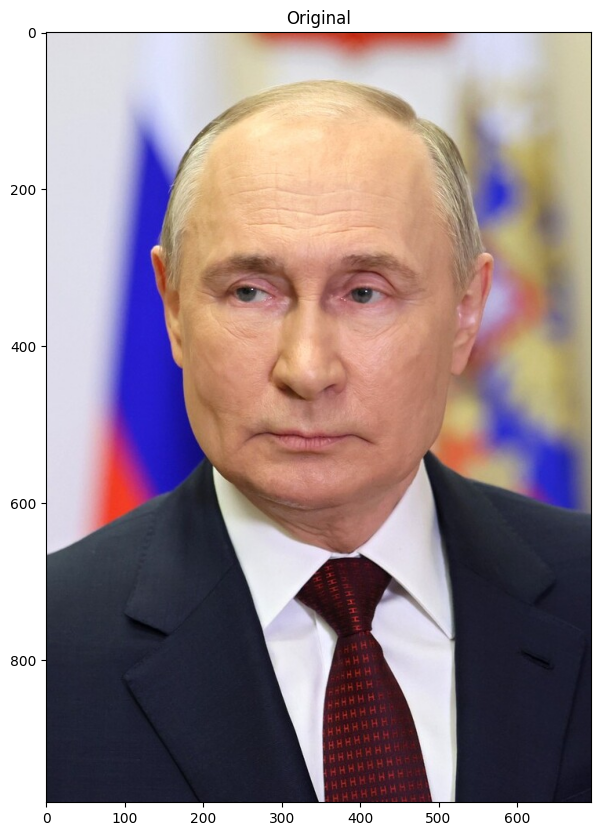

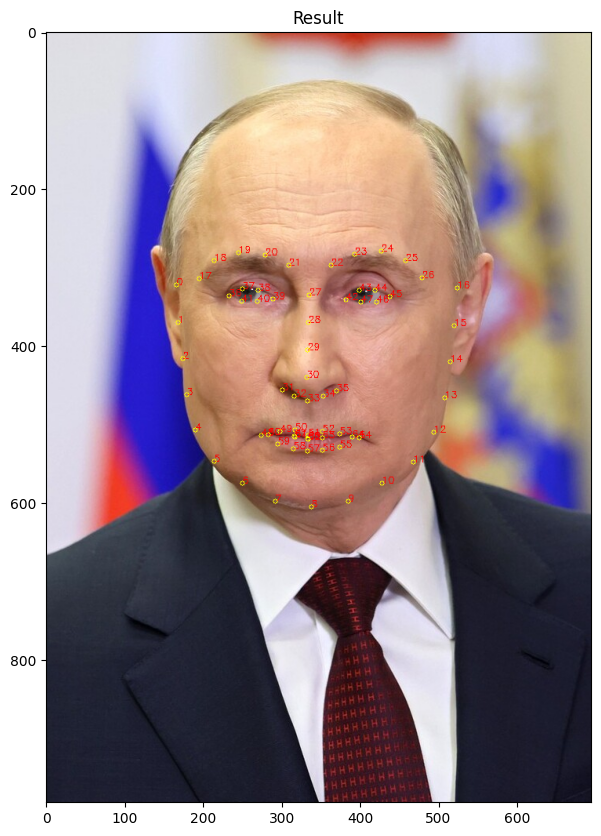

In [12]:
image = cv2.imread('images/putin.jpg')
imshow('Original', image)
landmarks = get_landmarks(image)
image_with_landmarks = annotate_landmarks(image, landmarks)
imshow('Result', image_with_landmarks)

## **Face Swapping**

Os passos principais para realizar o face swapping são:

Detectar os rostos e landmarks.

Calcular a transformação afim para alinhar os rostos.

Criar uma máscara para destacar as regiões do rosto.

Combinar o rosto transformado com a imagem de destino.

Ajustar as cores para uma transição mais suave.

In [13]:
import sys

PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1 
FEATHER_AMOUNT = 11 #Tamanho do kernel para suavização

FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61)) #boca
RIGHT_BROW_POINTS = list(range(17, 22)) #sobrancelha direita
LEFT_BROW_POINTS = list(range(22, 27)) #sobrancelha esquerda
RIGHT_EYE_POINTS = list(range(36, 42)) #Olho direito
LEFT_EYE_POINTS = list(range(42, 48)) #olho esquerdo
NOSE_POINTS = list(range(27, 35)) # nariz
JAW_POINTS = list(range(0, 17))

# Pontos usados ​​para alinhar as imagens.
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                               RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)

# Pontos da segunda imagem para sobrepor na primeira. O convexhull de cada
#elemento será sobreposto.
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# Quantidade de desfoque a ser usada durante a correção de cores, como uma fração da distância pupilar.
COLOUR_CORRECT_BLUR_FRAC = 0.6

detector = dlib.get_frontal_face_detector()
#Inicializa o detector de rostos frontal da biblioteca dlib. Ele é usado para localizar rostos na imagem.
predictor = dlib.shape_predictor(PREDICTOR_PATH)
# Cria um objeto preditor baseado no modelo especificado no caminho. Este modelo mapeia pontos faciais (landmarks).

class TooManyFaces(Exception):
    pass

class NoFaces(Exception):
    pass

In [14]:
def get_landmarks(im):
    # Returns facial landmarks as (x,y) coordinates
    rects = detector(im, 1)
    
    if len(rects) > 1:
        raise TooManyFaces
    if len(rects) == 0:
        raise NoFaces

    return np.matrix([[p.x, p.y] for p in predictor(im, rects[0]).parts()])


def annotate_landmarks(im, landmarks):
    #Sobrepõe os pontos de referência na própria imagem
    
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im, str(idx), pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im

In [15]:
def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points) #Retorna os pontos que formam a figura convexa
    # FillConvexPoly é usada para preencher uma região convexa em uma imagem com uma cor sólida. 
    # Ela desenha o polígono fornecido como argumento, preenchendo o interior com a cor especificada.
    cv2.fillConvexPoly(im, points, color=color)

def get_face_mask(im, landmarks):
    # Cria uma imagem vazia com o mesmo tamanho da imagem original,
    # mas com apenas um canal (em escala de cinza).
    im = np.zeros(im.shape[:2], dtype=np.float64)

    # Para cada grupo de pontos definidos em OVERLAY_POINTS, desenha-se o contorno.
    for group in OVERLAY_POINTS:
        draw_convex_hull(im,
                         landmarks[group],
                         color=1)

    # Transforma a máscara em uma imagem de 3 canais (RGB-like), duplicando o canal existente.
    im = np.array([im, im, im]).transpose((1, 2, 0))

    # Aplica um desfoque gaussiano para suavizar as bordas da máscara
    #O operador > transforma os valores borrados em uma máscara binária (1.0 para regiões do rosto e 0.0 para o fundo).
    im = (cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0) * 1.0
    # Aplica o desfoque gaussiano novamente para suavizar ainda mais a transição.
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

In [16]:
def transformation_from_points(points1, points2):
    #Calcula uma transformação afim entre dois conjuntos. Essa transformação minimiza o erro
    #quadratico entre os pontos transformados resolvendo o problema de Procrustes.
    #A função resolve o Problema de Procrustes Ortogonal para calcular a melhor transformação
    #  entre dois conjuntos de pontos em termos de rotação (R), escala (s) e translação (T)
    """
    Return an affine transformation [s * R | T] such that:
        sum ||s*R*p1,i + T - p2,i||^2
    is minimized.
    """
    # A função resolve o problema de Procrustes usando subtração dos centróides,
    # escalonamento pelos desvios padrões e cálculo da rotação por decomposição SVD.
    # https://pt.wikipedia.org/wiki/Problema_ortogonal_de_Procrustes

    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)
    # Garante que os pontos estejam no formato de ponto flutuante para evitar problemas de precisão.

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2
    # Calcula os centróides (médias) dos dois conjuntos de pontos.

    s1 = np.std(points1)
    s2 = np.std(points2)
    # Calcula o desvio padrão de cada conjunto de pontos.
    points1 /= s1
    points2 /= s2
    # Normaliza os pontos para que tenham escala uniforme, removendo o efeito do tamanho original.

    U, S, Vt = np.linalg.svd(points1.T * points2)

   # Realiza a decomposição SVD (Singular Value Decomposition) do produto matricial.
    # Aqui, `U` e `Vt` contêm as rotações, e `S` contém os valores singulares que ajudam
    # a encontrar a melhor aproximação linear entre os conjuntos de pontos.
    R = (U * Vt).T
    # Calcula a matriz de rotação ( R ). Transpõe o resultado para garantir a
    # aplicação correta de vetores coluna, conforme o contexto da transformação.

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                         np.matrix([0., 0., 1.])])

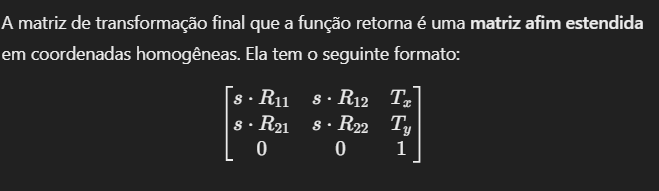

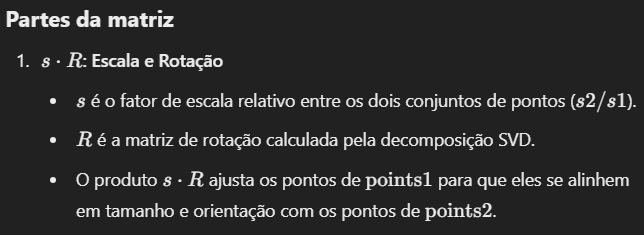

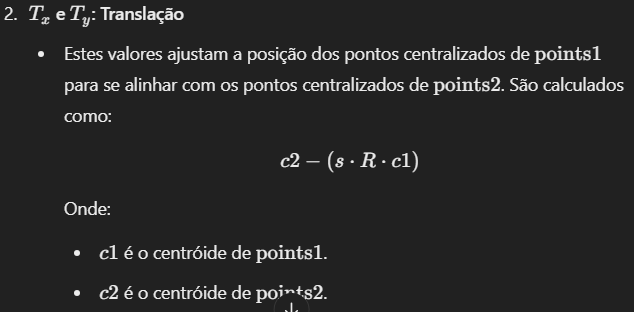

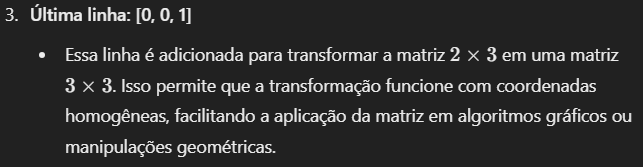

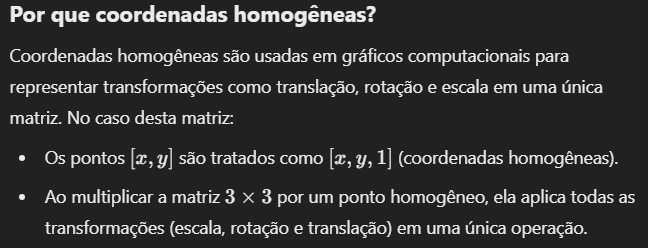

In [17]:
def read_im_and_landmarks(image):
    im = image
    im = cv2.resize(im, None, fx=1, fy=1, interpolation=cv2.INTER_LINEAR)
    # Redimensiona a imagem com um fator de escala (fx=1 e fy=1).
    # Aqui, `fx` e `fy` definem os fatores de escala horizontal e vertical.
    # A interpolação `cv2.INTER_LINEAR` é usada para redimensionamento suave.
    # OBS: Parece redundante, já que fx=1 e fy=1 mantêm a imagem no mesmo tamanho.
    
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR, im.shape[0] * SCALE_FACTOR))
    # Redimensiona novamente a imagem, mas agora aplica um fator de escala `SCALE_FACTOR`.
    # `im.shape[1]` é a largura e `im.shape[0]` é a altura.
    # O novo tamanho da imagem será ampliado ou reduzido pelo valor de `SCALE_FACTOR`.
    # Este passo pode ser útil para normalizar a escala da imagem para o processamento.
    s = get_landmarks(im)
    # Detecta os landmarks faciais na imagem redimensionada `im`.
    # A função `get_landmarks` provavelmente retorna as coordenadas dos pontos de interesse (olhos, nariz, boca, etc.).

    return im, s

In [18]:
def warp_im(im, M, dshape):
    # im: A imagem de entrada que será transformada.
    # M: A matriz de transformação afim (3x3) ou reduzida (2x3).
    # dshape: O formato da imagem de saída (altura, largura, canais).
    output_im = np.zeros(dshape, dtype=im.dtype)
    # Inicializa a imagem de saída como uma matriz de zeros.
    # Tem o mesmo tipo de dados (dtype) da imagem de entrada.
    # `dshape` define o tamanho da imagem transformada, incluindo número de canais (se colorida).
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    # cv2.warpAffine aplica a transformação afim à imagem de entrada `im`.
    # Parâmetros explicados:
    # - `M[:2]`: Usa apenas as duas primeiras linhas da matriz (2x3), que é suficiente para transformações afins.
    # - `(dshape[1], dshape[0])`: Define a largura e altura da imagem de saída.
    # - `dst=output_im`: Armazena o resultado na variável `output_im` criada anteriormente.
    # - `borderMode=cv2.BORDER_TRANSPARENT`: Define como lidar com bordas fora da imagem transformada; aqui, pixels fora do limite não são preenchidos.
    # - `flags=cv2.WARP_INVERSE_MAP`: Indica que a transformação é inversa (transforma os pixels da saída para a entrada), usada para alinhamento preciso.
    return output_im

In [ ]:
def correct_colours(im1, im2, landmarks1):
    #A função np.linalg.norm 
    # Esta função é capaz de retornar uma das oito normas matriciais diferentes, 
    # ou uma dentre um número infinito de normas vetoriais (descritas abaixo), dependendo do valor do parâmetro ord.
    blur_amount = COLOUR_CORRECT_BLUR_FRAC * np.linalg.norm(
                              np.mean(landmarks1[LEFT_EYE_POINTS], axis=0) -
                              np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0)) #Correção nos olhos
    blur_amount = int(blur_amount) #tras para int
    if blur_amount % 2 == 0: #se for par, transforma em impar
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0) #aplicando suavização nas duas imagens
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    #Evite erros de divisão por zero.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /
                                                im2_blur.astype(np.float64))

In [ ]:
def swappy(image1, image2):
       
    #Lendo os landmarks
    im1, landmarks1 = read_im_and_landmarks(image1)
    im2, landmarks2 = read_im_and_landmarks(image2)

    #matriz de transformação
    M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                   landmarks2[ALIGN_POINTS])
    
    #criando mascara
    mask = get_face_mask(im2, landmarks2)
    #aplicando na imagem 1
    warped_mask = warp_im(mask, M, im1.shape)
    #combinando
    combined_mask = np.max([get_face_mask(im1, landmarks1), warped_mask],
                              axis=0)

    #aplicando na imagem 2
    warped_im2 = warp_im(im2, M, im1.shape)
    # corrigindo cores da imagem 2
    warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

    
    output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask
    cv2.imwrite('output.jpg', output_im)
    image = cv2.imread('output.jpg')
    return image

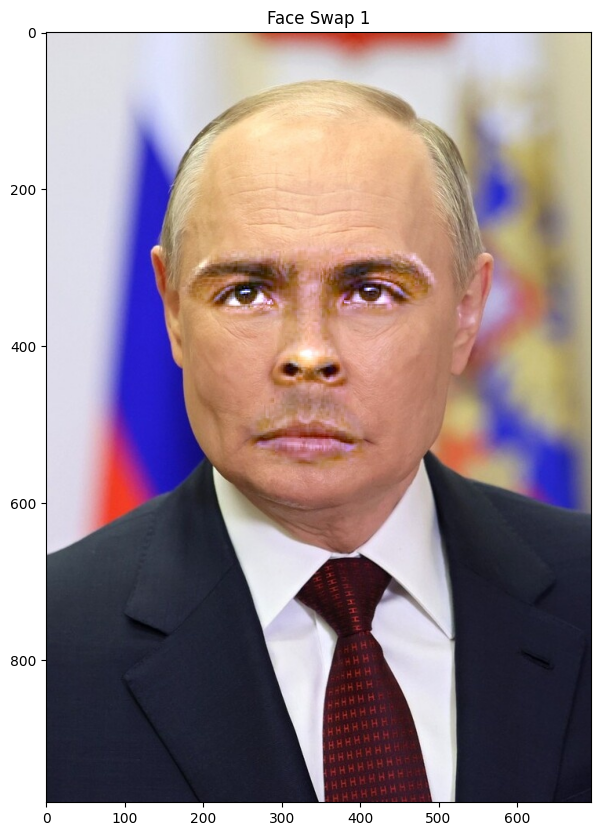

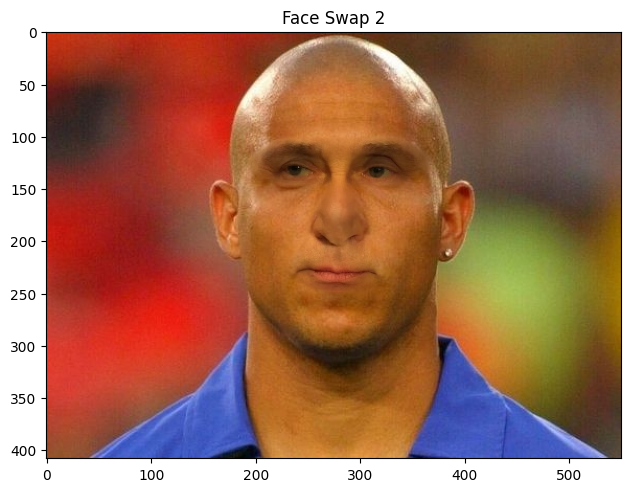

In [ ]:

## Enter the paths to your input images here    
image1 = cv2.imread('images/putin.jpg')
image2 = cv2.imread('images/ronaldo.jpg')

swapped = swappy(image1, image2)
imshow('Face Swap 1', swapped)

swapped = swappy(image2, image1)
imshow('Face Swap 2', swapped)    